_Ce notebook a été créé par Yann Vernaz (2017)._

<center>
<a href="https://www.meetup.com/fr-FR/Meetup-Machine-Learning-Pau/" ><img src="img/meetup_logo.png" style="float:left; max-width: 100px; display: inline" alt="Meetup"/></a> 
<a href="https://www.meetup.com/fr-FR/Meetup-Machine-Learning-Pau/" ><img src="img/meetup_ML_pau.png" style="float:center; max-width: 250px; display: inline"  alt="Meetup Machine Learning Pau"/></a>
<a href="http://www.helioparc.com" ><img src="img/helioparc_logo.svg" style="float:right; max-width: 200px; display: inline" alt="Technopole Héloparc"/> </a>
</center>
<br>
<hr>
<center><h1>Optimisation distribuée avec Apache Spark</h1></center>
<hr>
<center><h2>Lab 1 - Les algorithmes du Gradient</h2></center>
<hr>

Les algorithmes de __Descente du Gradient__ permettent de trouver le minimum local d'une fonction. Ce sont des algorithmes itératifs qui procèdent par améliorations successives. Au point courant, un déplacement est effectué dans la direction opposée au gradient, de manière à faire décroître la fonction objectif $J(\mathbf{w})$. La mise-à-jour des paramètres (aussi appelés poids) s'écrit sous la forme  suivante :

$$ \mathbf{w}_{k+1} := \mathbf{w}_k - \alpha_k\,\nabla J(\mathbf{w}_k)$$

où $\alpha_k$ est le pas ou taux d’apprentissage (_learning rate_) et $\nabla J(\mathbf{w})$ le gradient de la fonction objectif $J(\mathbf{w})$ à minimiser.

Après un court passage par l'[algorithme de Newton](#gd_2) (méthode du second ordre), l'objectif de ce _Notebook_ est d'explorer les trois méthodes principales lorsqu'on veut résoudre un problème _Big Data_ : 

   - [Batch Gradient Descent](#gd_1)
   - [Stochastic Gradient Descent](#sgd)
   - [Mini-Batch Gradient Descent](#mini_batch)

<!-- Elles diffèrent par la quantité de données utilisée pour calculer le gradient. En fonction du nombre de données disponibles, on doit faire un compromis entre la précision et le temps nécessaire pour effectuer une mise-à-jour. -->

Avant de conclure nous listons quelques récentes [extension et variantes](#sgd_variants).

In [1]:
from __future__ import print_function
import numpy as np
from random import randint
import timeit
import utilsLab1
import matplotlib.pyplot as plt
%matplotlib inline

## Les données

Dans ce _Lab_ nous utilisons un jeux de données simple (que vous pouvez (re)générer, _cf._ [utilsLab1.py](utilsLab1.py)) afin d'interpréter les avantages/faiblesses de chaque méthode.

In [2]:
# initialisation des poids
w = np.array([2., 3., -1.])

# génération des données
#utilsLab1.data_generate('data_training.csv', w, n=1000)
#utilsLab1.data_generate('data_test.csv', w, n=300)

In [3]:
# lecture des données d'apprentissage
x_train, y_train = utilsLab1.data_read('data_training.csv')

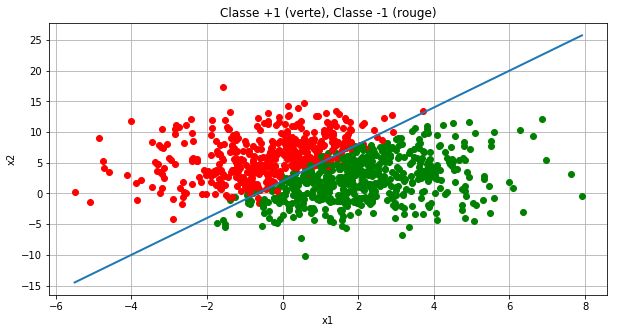

In [4]:
# visualisation des données d'apprentissage
utilsLab1.data_plot(x_train, y_train, w)

In [5]:
# mise à l'échelle des données d'apprentissage
x_train_scaled = utilsLab1.data_scaled(x_train)

## Rafraîchissement sur la régression logistique

Notre ensemble d'apprentissage $\mathcal{D} = \{[{\bf x}_i,y_i]\}_{i=1...n}$ contient $n$ *exemples* ; chaque exemple se compose d'un vecteur de variables ou *features* ${\bf x}_i\in\mathbb{R}^d$ et d'une *réponse* binaire ou *label* $y_i\in \{-1 , +1 \}$. 

La régression logistique est une méthode d'apprentissage supervisé qui va construire une fonction de prédiction des réponses à partir de notre base de données d'apprentissage et ainsi généraliser à des entrées inconnues. Étant donné un nouveau point, noté ${\bf x}_j$, le modèle fait une prédiction en appliquant la fonction logistique ou Sigmoïde :

$$f(z)=\frac{1}{1+\exp(-z)}\,\,\text{ avec }\,\,z={\bf w}^T{\bf x}_j\,\in\mathbb{R}$$

Par défaut, si $f({\bf w}^T{\bf x}_j)>0.5$, la prédiction est $-1$, sinon $+1$. 

Pour estimer le paramètre inconnu $\mathbf{w}\in\mathbb{R}^d$ à partir des données disponibles on minimise une *fonction de perte* $L(\mathbf{w};\mathbf{x}_i,y_i)$ qui pénalise l'erreur entre la prédiction et l'observation. On ajoute aussi généralement une régularisation, représentée par une fonction $R(\mathbf{w})$. On forme alors le problème d'optimisation suivant :

$$\mathbf{w}^\star := \min\limits_{\mathbf{w}\in\mathbb{R}^d} J(\mathbf{w})$$

avec

$$J(\mathbf{w}) := \frac{1}{n}\sum_{i=1}^n L(\mathbf{w};\mathbf{x}_i,y_i) + \lambda\, R(\mathbf{w})$$

Dans le cas de la régression logistique, la fonction de perte, son gradient et la matrice hessienne sont donnés par les expressions suivantes :

| Fonction de perte : $L(\mathbf{w};\mathbf{x}_i,y_i)$ | Gradient : $\nabla_\mathbf{w} L(\mathbf{w};\mathbf{x}_i,y_i)\in \mathbb{R}^d$ | Hessien : $\nabla^2 L(\mathbf{w};\mathbf{x}_i,y_i)\in \mathbb{R}^{d\times d}$ |
|:----|:-----|:----|
| $\log(1+\exp(-y_i\mathbf{w}^T \mathbf{x}_i))$ | $$-\frac{y_i}{1+\exp(y_i\mathbf{w}^T \mathbf{x}_i)}{\bf x}_i$$ | $$ \frac{\exp(y_i\mathbf{w}^T \mathbf{x}_i)}{\left [1+\exp(y_i\mathbf{w}^T \mathbf{x}_i) \right ]^2}{\bf x}_i^T{\bf x}_i$$ |

<!-- | perte quadratique | $\frac{1}{2} (\mathbf{w}^T \mathbf{x} - y)^2, \quad y \in \mathbb{R}$ | $(\mathbf{w}^T \mathbf{x} - y) \cdot \mathbf{x}$ | -->

Notons que, la valeur de la réponse (_label_) $y$ qui vaut $+1$ ou $-1$ permet d'obtenir des formules simples.

| Nom | Régularisation : $R(\bf{w})$ | Gradient : $\nabla R(\bf{w})\in \mathbb{R}^d$ | Hessien : $\nabla^2 R(\bf{w})\in \mathbb{R}^{d\times d}$ |
| :--- | :--- | :--- | :--- |
| $\ell_2$ ou Ridge ou Tikhonov | $\frac{1}{2}\,\|\bf{w}\|_2^2$ | $\bf{w}$ | $I_d$ |
| $\ell_1$ ou Lasso | $\|\bf{w}\|_1$ | $\mathrm{sign}(\bf{w})$ | $2\,\delta(\bf{w})$ |
| elastic net    | $\lambda_1\|\bf{w}\|_1 + \frac{\lambda_2}{2}\|\bf{w}\|_2^2$ | $\lambda_1\mathrm{sign}(\bf{w})+\lambda_2\bf{w}$ | $2\,\lambda_1\,\delta(\bf{w}) + \lambda_2\,I_d$ |

Ici $\mathrm{sign}(\bf{w})$ est le vecteur constitué des signes ($\pm1$) de toutes les entrées de $\bf{w}$ et $\delta(\bf{w})$ est la [fonction delta de Dirac](http://en.wikipedia.org/wiki/Dirac_delta_function). Cependant comme la fonction de régularisation n'est pas différentiable dans le cas $\ell_1$ ou Lasso nous utiliserons la fonction [_pseudo-Huber_](http://en.wikipedia.org/wiki/Huber_loss) pour approximer la norme $\ell_1$.

<!-- La régularisation $\ell_1$ favorise la parcimonie (i.e. la majorité des composants de $\bf{w}$ sont des zéros) tandis que la régularisation $\ell_2$ empêche le sur-ajustement (_overfitting_). Un vecteur $\bf{w}$ avec une norme $\ell_1$ petite a tendance à être une solution clairsemée. -->

## Oracles : $J(\mathbf{w}), \nabla J(\mathbf{w}), \nabla^2 J(\mathbf{w})$

La première étape consiste à écrire les _oracles_, c'est-à-dire les _routines_ qui permettent de calculer la fonction de perte, le gradient et la matrice hessienne. 

In [6]:
# oracles for
#   J        : logistic loss at w
#   gradJ    : gradient vector of J(w) at w
#   hessianJ : hessian matrix of J(w) at w

def J(x, y, w, lam1=0, lam2=0):
    n = len(y)
    Jval = np.sum(np.log(1. + np.exp(-y*np.dot(x, w))))
    return Jval/n + lam1*np.linalg.norm(w,1) + 0.5*lam2*np.dot(w,w)

def gradJ(x, y, w, lam1=0, lam2=0):
    n,d = x.shape
    gradient = np.zeros(d)
    g = -y*( 1./ ( 1. + np.exp(y*np.dot(x, w)) ) )
    gradient = np.dot(x.T, g)
    gradL1 = np.sum( np.divide(w, np.sqrt(1. + np.power(w,2))) )
    return gradient/n + lam1*gradL1 + lam2*w

def hessianJ(x, y, w, lam1=0, lam2=0):
    n,d = x.shape
    hessian = np.zeros((d,d))
    for i in range(n):
        z = np.exp(y[i]*np.dot(x[i], w))
        hessian += ( z / (( 1. + z)**2) ) * np.outer(x[i], x[i])
    hessianL1 = utilsLab1.pseudo_huber_hessian(w)*np.eye(d)
    return hessian/n + lam1*hessianL1 + lam2*np.eye(d)

In [7]:
H = hessianJ(x_train_scaled, y_train, w)
eigenvalues,eigenvectors = np.linalg.eig(H)
print("Hessian matrix : \n", H)
print("\nSpectum : \n", eigenvalues)
print("\nCondition number for H :", np.linalg.cond(H,p='fro'))
# La fonction de perte est bien convexe !

Hessian matrix : 
 [[ 0.09632935 -0.04347587  0.01911549]
 [-0.04347587  0.04655767  0.01122245]
 [ 0.01911549  0.01122245  0.09108234]]

Spectum : 
 [ 0.01629363  0.12540743  0.09226831]

Condition number for H : 9.83585064737


## <a id='gd_2'>Algorithme de Newton (2ième ordre)</a>

$$ \mathbf{w}_{k+1} := \mathbf{w}_k - [\nabla^2 J(\mathbf{w}_k) ]^{-1} \nabla J(\mathbf{w}_k)$$

#### Algorithme de Newton
&nbsp;&nbsp;&nbsp;    1: &nbsp; Choisir une valeur initiale $\mathbf{w}_0$ <br>
&nbsp;&nbsp;&nbsp;    2: &nbsp; <b>POUR</b> $k$ = 0, 1, 2, ... <b>FAIRE</b><br>
&nbsp;&nbsp;&nbsp;    3: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\mathbf{s}_k$ = $\nabla J(\mathbf{w}_k)$ <br>
&nbsp;&nbsp;&nbsp;    4: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\mathbf{H}_k$ = $\nabla^2 J(\mathbf{w}_k)$ <br>
&nbsp;&nbsp;&nbsp;    5: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\mathbf{w}_{k+1} = \mathbf{w}_k - \mathbf{H}_k^{-1} \mathbf{s}_k$ <br>
&nbsp;&nbsp;&nbsp;    6: &nbsp;  <b>FIN POUR</b>

Note - On peut également utiliser un test d'arrêt sur le gradient losque $\|\nabla J(\mathbf{w}_k)\| < \epsilon$, par exemple avec $\epsilon=1.e-4$. 

Notons qu'on peut éviter de construire explicitement la matrice hessienne en construisant une approximation de l'inverse de la dérivée seconde (méthode de Quasi-Newton). Par exemple, la populaire méthode **BFGS.** (Broyden-Fletcher-Goldfarb-Shanno, 1970) consiste à effectuer l'itération suivante :

$$\mathbf{w}_{k+1}:=\mathbf{w}_k - \alpha_k \mathbf{H}_k \nabla J(\mathbf{w}_k)$$

où $\alpha_k$ est le pas et la matrice définie positive $\mathbf{H}_k$ est calculée par :

$$ \mathbf{H}_{k+1}:=\mathbf{H}_k - \frac{s_k y_k^T \mathbf{H}_k+\mathbf{H}_k y_k s_k^T}{y_k^T s_k} +\left[1+\frac{y_k^T \mathbf{H}_k y_k}{y_k^T s_k}\right]\frac{s_k s_k^T}{y_k^T s_k} $$
avec $s_k=\mathbf{w}_{k+1}-\mathbf{w}_{k}$ et $y_k=\nabla J(\mathbf{w}_{k+1}) - \nabla J(\mathbf{w}_{k})$.

In [8]:
def newton(x, y, w0=None, lambda1=0.0, lambda2=0.0,
           iterations=100, EPS=1.e-4, progress=False):
        
    n,d = x.shape
    if w0 is None:
        w = np.random.normal(size=d)
    else:
        w = w0
       
    f = np.array([J(x,y,w)])
    gradient = gradJ(x, y, w, lam1=lambda1, lam2=lambda2)
    stop = EPS*np.linalg.norm(gradient)
    
    ts = timeit.default_timer()
    for k in range(iterations):
        
        gradient = gradJ(x, y, w, lam1=lambda1, lam2=lambda2)
        Hessian = hessianJ(x, y, w, lam1=lambda1, lam2=lambda2) 
        w += -np.linalg.solve(Hessian,gradient)
        
        fval = J(x,y,w)
        f = np.vstack((f, J(x,y,w)))
        
        # progress trace
        if (progress==True) and (k%(iterations/10) == 0):
            utilsLab1.show_progress(k,w,fval,gradient)
            
        #if np.linalg.norm(gradient) < stop:
        #    print("STOP NEWTON")
        #    break
    
    te = timeit.default_timer()
    
    if (progress==True):
        print("\n*** Newton Algorithm *** (", np.round(te-ts,2), "seconds)" )
        utilsLab1.show_progress(k,w,fval,gradient)
        
    return w,f.reshape(iterations+1,)

## <a id='gd_1'>Batch Gradient Descent</a>

&nbsp;&nbsp;&nbsp;    1: &nbsp; Choisir une valeur initiale $\mathbf{w}_0$ et un taux d'apprentissage $\alpha_0>0$.<br>
&nbsp;&nbsp;&nbsp;    2: &nbsp; <b>POUR</b> $k$ = 0, 1, 2, ... <b>FAIRE</b><br>
&nbsp;&nbsp;&nbsp;    3: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Calculer le gradient sur l'ensemble des données : $s_k = \frac{1}{n}\sum_{i=1}^n\nabla J_i(\mathbf{w}_{k})$ <br>
&nbsp;&nbsp;&nbsp;    5: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Mise-à-jour des poids : $\mathbf{w}_{k+1} = \mathbf{w}_{k} - \alpha_k\, s_k$ <br>
&nbsp;&nbsp;&nbsp;    6: &nbsp;  <b>FIN POUR</b>

Pour le choix du pas (ou *learning rate*), nous vous proposons une borne supérieure sur la constante de Lipschitz $\ell$ de $\nabla J(\mathbf{w})$ :

$ \ell \leq \ell_b = \frac{1}{4} \max\limits_{i} \|{\bf x}_i\|_{2}^2$ d'où $\alpha_k = \frac{1}{\ell_b}$

In [9]:
# learning rate
Lb = 0.25*np.max(np.linalg.norm(x_train_scaled, 2, axis=1))**2
LR = 1./Lb
print("Lipschitz upper bound", np.round(Lb, 4))
print("Learning rate: ", np.round(LR, 4))

Lipschitz upper bound 3.5157
Learning rate:  0.2844


In [10]:
def batchGD(x, y, w0=None, learningRate=0.05, momentum=0.0, nesterov=False,
            lambda1=0.0, lambda2=0.0, iterations=100, sampleSize=0, progress=False):
        
    n,d = x.shape
    v = np.zeros(d)
    if w0 is None:
        w = np.random.normal(size=d)
    else:
        w = w0
       
    f = np.array([J(x,y,w)]) 
    ts = timeit.default_timer()
    
    for k in range(iterations):
        if nesterov:
            w_nesterov = w - momentum*v
        else:
            w_nesterov = w
        
        gradient = gradJ(x, y, w_nesterov, lam1=lambda1, lam2=lambda2)
        v = momentum*v + learningRate*gradient
        w += -v
        
        fval = J(x,y,w)
        f = np.vstack((f, J(x,y,w)))
        
        # progress trace
        if (progress==True) and (k%(iterations/10) == 0):
            utilsLab1.show_progress(k,w,fval,gradient)
    
    te = timeit.default_timer()
    
    if (progress==True):
        print("\n*** Batch Gradient Descent *** (", np.round(te-ts,2), "seconds)" )
        utilsLab1.show_progress(k,w,fval,gradient)
        
    return w,f.reshape(iterations+1,)

On utilise la même initialisation afin de comparer les différentes versions de l'algorithme.

In [11]:
W_INITIAL = np.random.normal(size=3)
ITER_MAX = 200
print("Initialization, w0 =", W_INITIAL)

Initialization, w0 = [-0.17048005 -0.71685684  0.70388381]


In [12]:
w_newton, f_newton = newton(x_train_scaled, y_train,  w0=np.array(W_INITIAL),
                            lambda1=0.01, lambda2=0.0,
                            iterations=ITER_MAX, progress=True)

epoch 1     w=[ 0.36  1.91 -1.52]     f(w)=0.2323   Grad_f(w)=0.620657
epoch 21    w=[ 0.95  6.43 -4.96]     f(w)=0.1015   Grad_f(w)=0.003616
epoch 41    w=[ 1.07  7.32 -5.7 ]     f(w)=0.0970   Grad_f(w)=0.001303
epoch 61    w=[ 1.11  7.69 -6.  ]     f(w)=0.0957   Grad_f(w)=0.000588
epoch 81    w=[ 1.14  7.87 -6.15]     f(w)=0.0952   Grad_f(w)=0.000287
epoch 101   w=[ 1.15  7.95 -6.22]     f(w)=0.0950   Grad_f(w)=0.000145
epoch 121   w=[ 1.15  8.   -6.26]     f(w)=0.0949   Grad_f(w)=0.000074
epoch 141   w=[ 1.16  8.02 -6.28]     f(w)=0.0948   Grad_f(w)=0.000038
epoch 161   w=[ 1.16  8.03 -6.29]     f(w)=0.0948   Grad_f(w)=0.000020
epoch 181   w=[ 1.16  8.04 -6.29]     f(w)=0.0948   Grad_f(w)=0.000010

*** Newton Algorithm *** ( 1.63 seconds)
epoch 200   w=[ 1.16  8.04 -6.3 ]     f(w)=0.0948   Grad_f(w)=0.000006


In [13]:
w_gd, f_gd = batchGD(x_train_scaled, y_train, w0=np.array(W_INITIAL),
                     learningRate=LR, iterations=ITER_MAX, progress=False)

On utilise le _Momentum_, avec comme formule de mise-à-jour :

$$\left \{\begin{array}{l}
\mathbf{v}_{k+1} := \mu\,\mathbf{v}_k + \alpha_k\,\nabla J(\mathbf{w}_k) \\
\mathbf{w}_{k+1} := \mathbf{w}_k - \mathbf{v}_{k+1}
\end{array}\right .$$

In [14]:
w_gd_momentum, f_gd_momentum = batchGD(x_train_scaled, y_train, w0=np.array(W_INITIAL),
                                       learningRate=LR, momentum=0.9, nesterov=False,
                                       iterations=ITER_MAX, progress=False)

On utilise la méthode d'accélération de Nesterov :

$$\left \{\begin{array}{l}
\mathbf{v}_{k+1} := \mu\,\mathbf{v}_k + \alpha_k\,\nabla J(\mathbf{w}_k-\mu\,\mathbf{v}_k) \\
\mathbf{w}_{k+1} := \mathbf{w}_k - \mathbf{v}_{k+1}
\end{array}\right .$$

In [15]:
w_gd_nesterov, f_gd_nesterov = batchGD(x_train_scaled, y_train, w0=np.array(W_INITIAL),
                                       learningRate=LR, momentum=0.9, nesterov=True,
                                       iterations=ITER_MAX, progress=False)

Tracons la valeur de la fonction de perte en fonction du nombre d'itérations pour les trois méthodes précédente. 

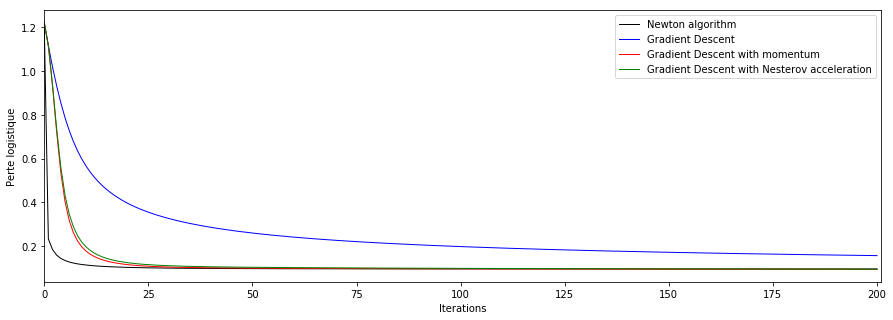

In [16]:
utilsLab1.iteration_plot(4, f=np.array([f_newton, f_gd, f_gd_momentum, f_gd_nesterov]).T,  
                         label=["Newton algorithm",
                                "Gradient Descent", 
                                "Gradient Descent with momentum", 
                                "Gradient Descent with Nesterov acceleration"])

### Régularisation Ridge

In [17]:
w_ridge,f_ridge = batchGD(x_train_scaled, y_train, w0=np.array(W_INITIAL), 
                          learningRate=LR, lambda2=0.005, 
                          iterations=ITER_MAX, progress=False)

### Régularisation Lasso (Least Absolute Shrinkage and Selection Operator)

In [18]:
w_lasso,f_lasso = batchGD(x_train_scaled, y_train, w0=np.array(W_INITIAL), 
                          learningRate=LR, lambda1=0.01, 
                          iterations=ITER_MAX, progress=False)

### Régularisation _Elastic Net_ 

In [19]:
w_net,f_net = batchGD(x_train_scaled, y_train, w0=np.array(W_INITIAL), 
                      learningRate=LR, lambda1=0.01, lambda2=0.005, 
                      iterations=ITER_MAX, progress=False)

...

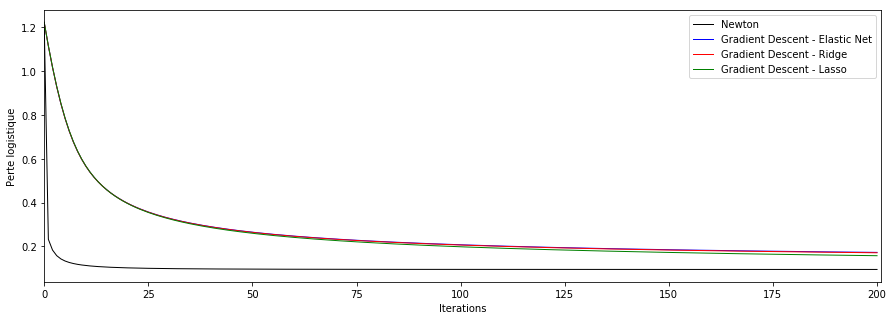

In [20]:
utilsLab1.iteration_plot(4, f=np.array([f_newton, f_net, f_ridge, f_lasso]).T,  
                         label=["Newton",
                                "Gradient Descent - Elastic Net", 
                                "Gradient Descent - Ridge", 
                                "Gradient Descent - Lasso"])

## <a id='sgd'>Stochastic Gradient Descent</a>

&nbsp;&nbsp;&nbsp;    0: &nbsp; Choisir une valeur initiale $\mathbf{w}_0$ et un taux d'apprentissage $\alpha_0>0$.<br>
&nbsp;&nbsp;&nbsp;    1: &nbsp; <b>POUR</b> $k$ = 0, 1, 2, ... <b>FAIRE</b><br>
&nbsp;&nbsp;&nbsp;    2: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Choisir aléatoirement un exemple $(\mathbf{x}_i,y_i)$ parmi l'ensemble d'apprentissage. <br>
&nbsp;&nbsp;&nbsp;    3: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Calculer le gradient avec l'example $(\mathbf{x}_i,y_i)$ : $s_k$ = $\nabla J_i(\mathbf{w}_{k})$ <br>
&nbsp;&nbsp;&nbsp;    4: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Mise-à-jour des poids : $\mathbf{w}_{k+1} = \mathbf{w}_{k} - \alpha_k\, s_k$ <br>
&nbsp;&nbsp;&nbsp;    5: &nbsp;  <b>FIN POUR</b>

In [21]:
def SGD(x, y, w0=None, learningRate=0.02, lambda1=0.0, lambda2=0.0, 
        iterations=1000, progress=False):
    
    n,d = x.shape
    if w0 is None:
        w = np.random.normal(size=d)
    else:
        w = w0

    f = np.array([J(x,y,w)])
    
    ts = timeit.default_timer()
    
    for k in range(iterations):
        
        # choose an example (xi, yi) randomly 
        i = randint(0, n-1)
        xi = x[i,:]
        yi = y[i]
        
        gradient = -yi*(1. - 1./(1. + np.exp(-yi*np.dot(xi, w))))*np.array(xi) \
            + lambda1*np.sign(w) + lambda2*w
        w += - learningRate*gradient
        
        fval = J(x,y,w)
        f = np.vstack((f, fval))
        
        # progress trace
        if (progress==True) and (k%(iterations/10)==0):
            utilsLab1.show_progress(k,w,fval,gradient)
    
    te =  timeit.default_timer()
    
    if (progress==True):
        print("\n*** Stochastic Gradient Descent *** (", np.round(te-ts,2), "seconds)")
        utilsLab1.show_progress(k,w,fval,gradient)
    
    return w,f.reshape(iterations+1,)

In [22]:
w_sgd, f_sgd = SGD(x_train_scaled, y_train, w0=np.array(W_INITIAL),
                   learningRate=LR, iterations=ITER_MAX, progress=False)

Comparons la méthode **Batch Gradient Descent** avec la méthode **Stochastic Gradient Descent**.

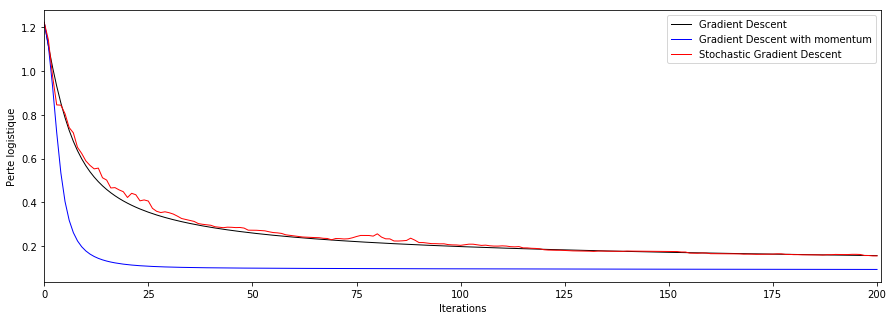

In [23]:
utilsLab1.iteration_plot(3, f=np.array([f_gd, f_gd_momentum, f_sgd]).T,  
                         label=["Gradient Descent", 
                                "Gradient Descent with momentum",
                                "Stochastic Gradient Descent"])

## <a id='mini_batch'>Mini-Batch (Stochastic) Gradient Descent</a>

&nbsp;&nbsp;&nbsp;    0: &nbsp; Choisir une valeur initiale $\mathbf{w}_0$ et un taux d'apprentissage $\alpha_0>0$.<br>
&nbsp;&nbsp;&nbsp;    1: &nbsp; <b>POUR</b> $k$ = 0, 1, 2, ... <b>FAIRE</b><br>
&nbsp;&nbsp;&nbsp;    2: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Choisir aléatoirement un échantillon des données de taille $m\ll n$, qu'on notera $\mathcal{D}_m$. <br>
&nbsp;&nbsp;&nbsp;    3: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Calculer le gradient avec l'échantillon  $\mathcal{D}_m$ : $s_k$ = $\frac{1}{m}\sum_{i=1}^{m}\nabla J_i(\mathbf{w}_{k})$ <br>
&nbsp;&nbsp;&nbsp;    4: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Mise-à-jour des poids : $\mathbf{w}_{k+1} = \mathbf{w}_{k} - \alpha_k\, s_k$ <br>
&nbsp;&nbsp;&nbsp;    5: &nbsp;  <b>FIN POUR</b>

In [24]:
def miniBatchGD(x, y, w0=None, learningRate=0.02, momentum=0.0, nesterov=False, 
                lambda1=0.0, lambda2=0.0,
                iterations=10, sampleSize=10, progress=False):
    
    n,d = x.shape
    v = np.zeros(d)
    if w0 is None:
        w = np.random.normal(size=d)
    else:
        w = w0
    
    f = np.array([J(x,y,w)])   
    
    ts = timeit.default_timer()
    
    for k in range(iterations):
        
        # choose randomly sampleSize examples (sampling)
        sampleX, sampleY = utilsLab1.sampling(x, y, size=sampleSize)
        
        if nesterov:
            w_nesterov = w - momentum*v
        else:
            w_nesterov = w
        
        gradient = gradJ(sampleX, sampleY, w_nesterov, lam1=lambda1, lam2=lambda2)
        v = momentum*v + learningRate*gradient
        w += -v
        
        fval = J(x,y,w)
        f = np.vstack((f, fval))
        
        # progress trace
        if (progress==True) and (k%(iterations/10)==0):
            utilsLab1.show_progress(k,w,fval,gradient)
    
    te =  timeit.default_timer()  
    
    if (progress==True):
        print("\n*** Mini-Batch Gradient Descent *** (", np.round(te-ts,2), "seconds)")
        utilsLab1.show_progress(k,w,fval,gradient)
        
    return w,f.reshape(iterations+1,)

In [25]:
w_miniGD, f_miniGD = miniBatchGD(x_train_scaled, y_train, w0=np.array(W_INITIAL), 
                                 learningRate=LR,
                                 iterations=ITER_MAX, sampleSize=10,
                                 progress=False)

In [26]:
w_miniGD_m, f_miniGD_m = miniBatchGD(x_train_scaled, y_train, w0=np.array(W_INITIAL),
                                     learningRate=LR, momentum=0.9, nesterov=True,
                                     iterations=ITER_MAX, sampleSize=10, 
                                     progress=False)

Comparons les méthodes **Batch Gradient Descent** et **Mini-Batch Gradient Descent**.

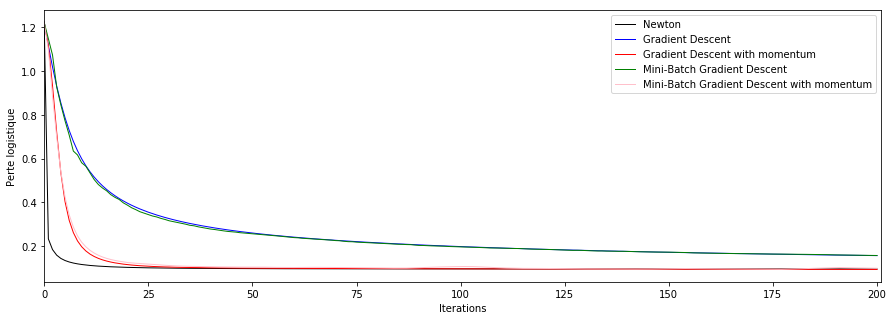

In [27]:
utilsLab1.iteration_plot(5, f=np.array([f_newton, f_gd, f_gd_momentum, f_miniGD, f_miniGD_m]).T,  
                         label=["Newton",
                                "Gradient Descent", 
                                "Gradient Descent with momentum", 
                                "Mini-Batch Gradient Descent",
                                "Mini-Batch Gradient Descent with momentum"])

Il est clair que la méthode **Mini-Batch Gradient Descent** prend le meilleur des méthodes **Batch Gradient Descent** et **Stochastic Gradient Descent**.

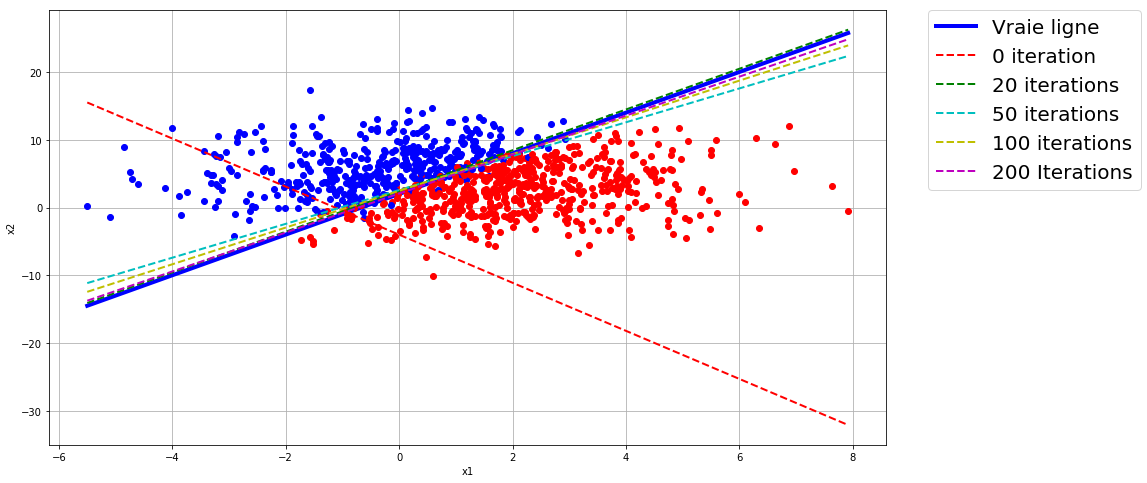

In [28]:
utilsLab1.data_plot_solution(x_train, y_train, w,  miniBatchGD)

In [29]:
# lecture des données de test
x_test, y_test = utilsLab1.data_read('data_test.csv')

# mise à l'échelle des données de test
x_test_scaled = utilsLab1.data_scaled(x_test)

pred = []
for i in range(len(y_test)):
    xi = x_test_scaled[i]
    yi = y_test[i]
    pred.append(yi==utilsLab1.prediction(xi,w_miniGD_m,0.5))
    
print("Prediction accuracy:", np.round(100.*sum(pred)/len(pred),2), "%")

Prediction accuracy: 96.33 %


## <a id='sgd_variants'>Extensions et variantes</a>

La plupart de ces variantes sont implémentées dans [_Tensorflow_](https://www.tensorflow.org).

### AdaGrad (gradient adaptatif)

Duchi, John; Hazan, Elad; Singer, Yoram (2011). "Adaptive subgradient methods for online learning and stochastic optimization". [JMLR](http://jmlr.org/papers/volume12/duchi11a/duchi11a.pdf). 12: 2121–2159.

AdaGrad a été appliqué avec succès à des problèmes non-convexe (Neural Network).

### RMSProp (Root Mean Square Propagation)

Tieleman, Tijmen and Hinton, Geoffrey (2012). Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude. COURSERA: Neural Networks for Machine Learning.

### Adam (Adaptive Moment Estimation) & AdaMax

Diederik, Kingma; Ba, Jimmy (2014). "Adam: A method for stochastic optimization".  [arXiv:1412.6980](http://arxiv.org/abs/1412.6980)

### Nadam

Dozat, T. (2016). Incorporating Nesterov Momentum into Adam. ICLR Workshop, (1), 2013–2016.

### Adadelta

Zeiler, Matthew D. (2012). "ADADELTA: An adaptive learning rate method". [arXiv:1212.5701](http://arxiv.org/abs/1212.5701)

### kSGD (Kalman-based Stochastic Gradient Descent)

Patel, V. (2016). "Kalman-Based Stochastic Gradient Method with Stop Condition and Insensitivity to Conditioning". SIAM Journal on Optimization. 26 (4): 2620–2648.


# Conclusion

Les méthodes diffèrent par la quantité de données utilisée pour calculer le gradient. En fonction du nombre de données disponibles, on doit faire un compromis entre la précision et le temps nécessaire pour effectuer une mise-à-jour.

| Méthode | Précision | Temps | Utilisation mémoire | Online Learning |
|---------|---------|---------|---------|---------|
| 2nd order (Newton, Quasi-Newtion) | ++ | ++ | -- | -- |
| Batch Gradient Descent | + | - | - | - |
| Stochastic Gradient Descent | - | ++ | ++ | + |
| Mini-Batch Gradient Descent | + | + | + | + |

1. Si les données tiennent en mémoire utilisez la méthode  **Batch Gradient Descent** mais en utilisant des méthodes pour accélérer l'apprentissage, voire même des méthodes du second ordre (Quasi-Newtion L-BFGS, gradient conjugué, ...).
<br><br>
2. Sinon utilisez **Mini-Batch Gradient Descent**.<br>
En effet, moins de calculs sont nécessaires pour calculer le gradient et mettre à jour les poids. De plus dans de nombreux cas on peut calculer le gradient de manière parallèle (cf. [Lab2](Lab2_Meetup_Pau.ipynb)). On peut utiliser des librairies de calcul matricielles très efficaces, notamment sur les GPUs.<br><br>
**Mini-Batch Gradient Descent** est beaucoup plus rapide, surtout lorsque l'ensemble d'entraînement est redondant (contient de nombreux points similaires). Il peut-être utilisé lorsqu'il n'y a pas d'ensemble d'entraînement fixe et que les données ne cessent d'arriver (_online learning_).<br><br>
Fonctionne mieux pour les environnements non stationnaires (où le meilleur modèle change régulièrement avec le temps).
Le bruit (les fluctuations de poids) peut aider à échapper aux minimums locaux (qui sont un problème pour Batch Gradient Descent).

